# Web scraping

In [1]:
import threading
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import psycopg2
from concurrent.futures import ThreadPoolExecutor
import time
import os

## Data Collecting

### Get Teachers Links

In [2]:
# Initialize a global lock for printing
print_lock = threading.Lock()

def fetch_links(url, language, page_num):
    """
    Read one page from url with the specified language, collecting all the teachers links to their personal cards for this page_num.
    Each teacher link contains substring "en/teacher/\d+/{language}", e.g. english teachers links must be like "/en/teacher/6454492/english"
    Each teacher personal card contains all necessary info about the teacher:
    - Name
    - Number of lessons
    - Number of students
    - Rating
    - Number of reviews
    - Attendance(%)	
    - Response(%)
    - Price (USD)

    Return: 
    teachers_links_per_page: list of links on teachers personal cards who teach specified language for the specified page_num
    page_num: number of page from where teachers links were retrieved
    """

    teachers_links_per_page = []
    response = requests.get(f"{url}/{language}?page={page_num}")
    if response.status_code != 200:
        with print_lock:
            print("Error: page doesn't load properly")
        return [], page_num

    # Check if we've reached the end of the pages
    phrase = "We couldn’t find any teachers for this language. Want to try another?"
 
    if phrase in response.text:
        return None, page_num  # Signal that we've reached the end

    soup = BeautifulSoup(response.text, "html.parser")
    href_elements = soup.select('[href]')
    filter = re.compile(rf'^/en/teacher/\d+/{language}$')

    for element in href_elements:
        link = element.get('href')
        if filter.match(link):
            teachers_links_per_page.append(f"https://www.italki.com{link}")

    return teachers_links_per_page, page_num


def get_teachers_links(url, language):
    """
    Manages threading using ThreadPoolExecutor. It submits tasks for 10 pages at a time and waits for all tasks 
    to complete before moving to the next set of pages. 
    If None is returned by any task, it stops further submission.
    max_workers: This is set to 10, which means up to 10 threads can run concurrently.

    Return: 
    teachers_links: list of links on teachers personal cards who teach specified language for all possible pages.
    """
    
    page_num = 1
    teachers_links = []
    end_reached = False
    
    with ThreadPoolExecutor(max_workers=10) as executor:
        while not end_reached:
            futures = [executor.submit(fetch_links, url, language, num) for num in range(page_num, page_num+10)]
            page_num += 10

            for future in futures:
                result = future.result()
                if result[0] is None:
                    end_reached = True
                    with print_lock:
                        print(f"All '{language}' teachers links were extracted, overall num = {len(set(teachers_links))}, last page_num = {result[1]}")
                    break
                teachers_links.extend(result[0])
            
    teachers_links = list(set(teachers_links))
    return teachers_links

def get_all_teachers_links(url, languages):
    """
    run get_teachers_links() for each language from languages

    Return: 
    all_teachers_links: links to teachers personal card for each language from languages
    """

    all_teachers_links = []
    for language in languages:
        all_teachers_links.extend(get_teachers_links(url, language))

    return all_teachers_links



In [3]:
url = "https://www.italki.com/en/teachers/"
languages = ['english', 'spanish', 'russian', 'japanese', 'italian']

# get all teachers links to their personal card
all_teachers_links = get_all_teachers_links(url, languages)
print(f"All teachers links were collected, overall num = {len(all_teachers_links)}")

All 'english' teachers links were extracted, overall num = 779, last page_num = 101
All 'spanish' teachers links were extracted, overall num = 781, last page_num = 101
All 'russian' teachers links were extracted, overall num = 628, last page_num = 34
All 'japanese' teachers links were extracted, overall num = 783, last page_num = 101
All 'italian' teachers links were extracted, overall num = 695, last page_num = 37
All teachers links were collected, overall num = 3666


### Create Table Teachers-Languages

In [4]:
def create_table_teachers_languages(all_teachers_links):
    """
    Create a table where with columns:
    - teacher_language_id: number of unique record (starting from 1) 
    - teacher_id: personal number of teacher (all teachers have their personal number on https://www.italki.com/,
      that can be obtained from teacher link to his/her personal card. Column teacher_id can contain non-unique values,
      because some teachers can teach multiple languages)
    - language_id: abbreviation of language
    """

    # Mapping full language names to their abbreviations
    language_map = {
        'english': 'eng',
        'spanish': 'sp',
        'japanese': 'jpn',
        'italian': 'it',
        'russian': 'ru'
    }

    # Extracting data from links
    data = []
    for index, link in enumerate(all_teachers_links, start=1):
        # Regex to extract the teacher ID and language
        match = re.search(r'/teacher/(\d+)/(\w+)', link)
        if match:
            teacher_id = int(match.group(1))
            language = str(match.group(2).lower())
            # Map the language to its abbreviation
            language_id = language_map.get(language, 'unknown')
            data.append([index, teacher_id, language_id])

    # Create DataFrame
    df = pd.DataFrame(data, columns=['teachers_languages_id', 'teacher_id', 'language_id'])
    return df



In [5]:
# create table teachers_languages
teachers_languages_df = create_table_teachers_languages(all_teachers_links)
print(f"Dataframe teachers_languages_df was created [{teachers_languages_df.shape[0]} rows x {teachers_languages_df.shape[1]} columns]")


# create table languages
languages = {
    'language_id': ['eng', 'sp', 'ru', 'jpn', 'it'],
    'language': ['English', 'Spanish', 'Russian', 'Japanese', 'Italian']
}
languages_df = pd.DataFrame(languages)
print(f"Dataframe languages was created [{languages_df.shape[0]} rows x {languages_df.shape[1]} columns]")

Dataframe teachers_languages_df was created [3666 rows x 3 columns]
Dataframe languages was created [5 rows x 2 columns]


### Get Teachers Info

In [40]:
def param_process(param):
    """
    processing the values from the teachers cards:
    '1,496' -> 1496
    '12.7k' -> 1270
    '525' -> 525

    Return:
    param: processed value    
    """
    
    if "," in param:
        param = int(param.replace(",", ""))
        
    elif "k" in param:
        param_num = param.replace("k", "")
        param = int(float(param_num) * 1000)
        
    else:
        param = int(param)        
    return param
    

def get_teacher_info(teacher_link):
    """
    Using link on teachers card, extract necessary parameters for this teacher:
    Name, Country, Rating, Students, Lessons, Attendance, Response, Reviews, Price.
    Then create a dictionary for this teacher using extracted values.
    
    Return: the dictionary, where this dictionary contains info about some teacher.
    """

    teacher_dict = {}
    response = requests.get(teacher_link)
    if response.status_code != 200:
        return None  # Handle HTTP errors
    
    soup = BeautifulSoup(response.text, 'html.parser')

    list_params = []
    # Name, Country, Rating, Students, Lessons, Attendance, Response
    for par in soup.select(".h4"):
        list_params.append(par.text.strip())

    empty_params_flag = False
    # some teachers didn't specify their Rating, Students, Lessons, Attendance, Response. So we put 0 to this parameters
    if len(list_params) == 1:
        list_params.extend([0, 0, 0, 0, 0])
        
        empty_params_flag = True

    # Reviews
    review = soup.select_one("#reviews .text-gray1")
    if review:
        list_params.append(review.text.strip())

    # Price
    price = soup.select_one(".text-lg.font-bold")
    if price:
        list_params.append(price.text.strip())

    # Country
    country_text = soup.select_one("#readmore .text-gray2 > span:nth-child(1)")
    if country_text:
        country = country_text.text[5:]
        list_params.append(country.strip())

    
    # fill in the dictionary
    teacher_dict["teacher_id"] = int(re.search(r'/teacher/(\d+)', teacher_link).group(1))
    teacher_dict["name"] = list_params[0]
    teacher_dict["country"] = list_params[8]

    if not empty_params_flag:
        teacher_dict["rating"] = float(list_params[1])
        teacher_dict["rating"] = float(list_params[1])
        teacher_dict["students"] = param_process(list_params[2])
        teacher_dict["lessons"] = param_process(list_params[3])
        teacher_dict["attendance"] = int(re.search(r'\d+', list_params[4]).group())
        teacher_dict["response"] = int(re.search(r'\d+', list_params[5]).group())

    else: # in case of None values for rating, students, lessons, attendance, response
        teacher_dict["rating"] = list_params[1]
        teacher_dict["students"] = list_params[2]
        teacher_dict["lessons"] = list_params[3]
        teacher_dict["attendance"] = list_params[4]
        teacher_dict["response"] = list_params[5]


    reviews_text = re.search(r'\d+', list_params[6])
    teacher_dict["reviews"] = 0 if reviews_text is None else param_process(reviews_text.group())

    price_text = re.search(r'\d+\.\d+', list_params[7])
    teacher_dict["price"] = 0.0 if price_text is None else float(price_text.group())

    # Process to strip off the language part, so
    # https://www.italki.com/en/teacher/7525061/spanish -> https://www.italki.com/en/teacher/7525061
    teacher_dict["link"] = teacher_link.rsplit('/', 1)[0]
    
    return teacher_dict


def create_table_teachers(all_teachers_links):
    """
    Manages threading using ThreadPoolExecutor by running process_teacher_link() for 10 threads at the same time. 
    It submits tasks for 10 teachers links at a time and waits for all tasks 
    to complete before moving to the next set of links. 
    max_workers: This is set to 10, which means up to 10 threads can run concurrently.

    Return: 
    teachers_df: a DataFrame made with list of dicts where each dict contains all info about the teacher.
    """
    teachers_dicts = []
    with ThreadPoolExecutor(max_workers=10) as executor:
        results = list(executor.map(get_teacher_info, all_teachers_links))

    # Filter out None results and extend the list
    teachers_dicts.extend([result for result in results if result is not None])

    teachers_df = pd.DataFrame(teachers_dicts)
    # each row in table teachers_df must represent unique teacher
    teachers_df = teachers_df.drop_duplicates(['teacher_id'])
    return teachers_df

In [41]:
# create table teachers
teachers_df = create_table_teachers(all_teachers_links)
print(f"Dataframe teachers was created [{teachers_df.shape[0]} rows x {teachers_df.shape[1]} columns]")

Dataframe teachers was created [3508 rows x 11 columns]


### Create csv-files

In [42]:
teachers_df.to_csv('teachers.csv', index=False)
teachers_languages_df.to_csv('teachers_languages.csv', index=False)
languages_df.to_csv('languages.csv', index=False)


In [27]:
def get_teacher_info_test(teacher_link):
    """
    Using link on teachers card, extract necessary parameters for this teacher:
    Name, Rating, Students, Lessons, Attendance, Response, Reviews, Price.
    Then create a dictionary for this teacher using extracted values.
    
    Return: the dictionary, where this dictionary contains info about some teacher.
    """

    teacher_dict = {}
    response = requests.get(teacher_link)
    if response.status_code != 200:
        return None  # Handle HTTP errors

    soup = BeautifulSoup(response.text, 'html.parser')

    list_params = []
    # Name, Country, Rating, Students, Lessons, Attendance, Response
    for par in soup.select(".h4"):
        list_params.append(par.text.strip())

    empty_params_flag = False
    # some teachers didn't specify their Rating, Students, Lessons, Attendance, Response. So we put 0 to this parameters
    if len(list_params) == 1:
        list_params.extend([0, 0, 0, 0, 0])
        
        empty_params_flag = True

    # Reviews
    review = soup.select_one("#reviews .text-gray1")
    if review:
        list_params.append(review.text.strip())

    # Price
    price = soup.select_one(".text-lg.font-bold")
    if price:
        list_params.append(price.text.strip())

    # Country
    country_text = soup.select_one("#readmore .text-gray2 > span:nth-child(1)")
    if country_text:
        country = country_text.text[5:]
        list_params.append(country.strip())

    
    # fill in the dictionary
    teacher_dict["teacher_id"] = int(re.search(r'/teacher/(\d+)', teacher_link).group(1))
    teacher_dict["name"] = list_params[0]
    teacher_dict["country"] = list_params[8]

    if not empty_params_flag:
        teacher_dict["rating"] = float(list_params[1])
        teacher_dict["rating"] = float(list_params[1])
        teacher_dict["students"] = param_process(list_params[2])
        teacher_dict["lessons"] = param_process(list_params[3])
        teacher_dict["attendance"] = int(re.search(r'\d+', list_params[4]).group())
        teacher_dict["response"] = int(re.search(r'\d+', list_params[5]).group())

    else: # in case of None values for rating, students, lessons, attendance, response
        teacher_dict["rating"] = list_params[1]
        teacher_dict["students"] = list_params[2]
        teacher_dict["lessons"] = list_params[3]
        teacher_dict["attendance"] = list_params[4]
        teacher_dict["response"] = list_params[5]


    reviews_text = re.search(r'\d+', list_params[6])
    teacher_dict["reviews"] = 0 if reviews_text is None else param_process(reviews_text.group())

    price_text = re.search(r'\d+\.\d+', list_params[7])
    teacher_dict["price"] = 0.0 if price_text is None else float(price_text.group())

    # Process to strip off the language part, so
    # https://www.italki.com/en/teacher/7525061/spanish -> https://www.italki.com/en/teacher/7525061
    teacher_dict["link"] = teacher_link.rsplit('/', 1)[0]
    
    return teacher_dict

In [30]:
teacher_link = all_teachers_links[7]
teacher_dict = get_teacher_info_test(teacher_link)
teacher_dict

{'teacher_id': 6616436,
 'name': 'Abdelrhman',
 'country': 'Egypt',
 'rating': 5.0,
 'students': 160,
 'lessons': 931,
 'attendance': 98,
 'response': 100,
 'reviews': 197,
 'price': 5.0,
 'link': 'https://www.italki.com/en/teacher/6616436'}

In [ ]:
def load_data_to_postgres(df, table_name, database, user, password, host='localhost'):
    """
    Load data from a pandas DataFrame to a PostgreSQL table using psycopg2.
    We skip rows where the primary key already exists in the database.

    Args:
    df (pandas.DataFrame): DataFrame containing the data to load.
    table_name (str): Name of the target table in the PostgreSQL database.
    database (str): Name of the PostgreSQL database.
    user (str): Username for the database.
    password (str): Password for the database.
    host (str): Database server host (default is 'localhost').
    """
    # Connect to the PostgreSQL database
    conn = psycopg2.connect(database=database, user=user, password=password, host=host)
    cur = conn.cursor()
    
    # Prepare the INSERT INTO statement with ON CONFLICT DO NOTHING
    cols = ','.join(df.columns)
    values = ','.join(['%s'] * len(df.columns))
    query = f"INSERT INTO {table_name} ({cols}) VALUES ({values}) ON CONFLICT ({df.columns[0]}) DO NOTHING"

    # Execute the query row by row to track progress
    rows_loaded_num = 0
    rows_skipped_num = 0
    for row in df.itertuples(index=False, name=None):
        cur.execute(query, row)
        if cur.rowcount > 0:  # rowcount is 0 if the row was not inserted due to a conflict
            rows_loaded_num += 1
        else:
            rows_skipped_num += 1
        conn.commit()  # Commit each row to ensure data consistency, can be moved outside the loop for performance

    # Close the connection
    cur.close()
    conn.close()
    print(f"Data successfully loaded into {table_name}, {rows_loaded_num} rows were loaded, {rows_skipped_num} were skipped")



# Analysis of dataset

In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Dataset descripton:**

The dataset contains the main set of characteristics of all English language teachers from the website https://www.italki.com/en/teachers/english.

- **Name**: The name of the teacher's card on the website (Nominal Categorical Variable).
- **Rating**: The rating of the teacher in the range from 0 to 5 (Continuous Numerical Variable).
- **Students**: The number of students the teacher had (Discrete Numerical Variable).
- **Lessons**: The number of lessons that the teacher has conducted (Discrete Numerical Variable).
- **Attendance(%)**: The percentage of classes the teacher has successfully attended without cancellations or no-shows (Continuous Numerical Variable).
- **Response(%)**: The percentage of times the teacher replies to messages or lesson requests (Continuous Numerical Variable).
- **Reviews**: The number of reviews the teacher has (Discrete Numerical Variable).
- **Price(USD)**: The price for one Trial lesson in USD (Continuous Numerical Variable).
- **Link**: The link on the teacher's card (Nominal Categorical Variable)(with only unique values). 

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           723 non-null    object 
 1   Rating         723 non-null    float64
 2   Students       723 non-null    int64  
 3   Lessons        723 non-null    int64  
 4   Attendance(%)  723 non-null    int64  
 5   Response(%)    723 non-null    int64  
 6   Reviews        723 non-null    int64  
 7   Price(USD)     723 non-null    float64
 8   Link           723 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 51.0+ KB


**Research question**: what is the impact of different teacher's characteristics on the teacher's price for one Trial lesson ?

## Univariate plots

### Rating

In [219]:
# Unique elements of Rating:
print(df['Rating'].unique())

[4.9 5.  4.8 4.7 4.6]


Since we have 5 unique values of variable Rating, the variable refers to categorical variable, so let's build the count-plot for it.

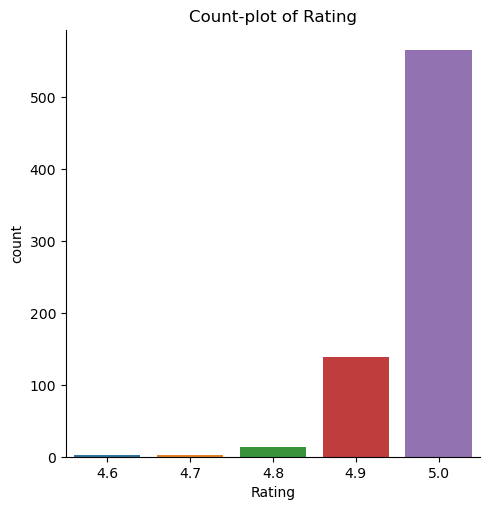

In [220]:
# Rating

sns.catplot(x='Rating', data=df, kind='count')
plt.title('Count-plot of Rating')
plt.show()

The count-plot shows that the greater rating the teacher has, the greater the number of such teachers.

In [264]:
Rating_count = pd.DataFrame(df['Rating'].value_counts())

list_prop = []
for val in Rating_count.index:
    count = Rating_count.loc[val, 'Rating']
    list_prop.append(count/df.shape[0] * 100)
    
Rating_count['Proportion(%)'] = list_prop
Rating_count.columns = ['Rating_count', 'Proportion(%)']
Rating_count

,Rating_count,Proportion(%)
5.0,565,78.146611
4.9,139,19.225450
4.8,14,1.936376
4.7,3,0.414938
4.6,2,0.276625


The most frequent rating is 5.0 with number of 565, which makes up about 78% of all ratings.

The least frequent one is 4.6 with number of 2, which makes up about 0.3% of all ratings.

### Students

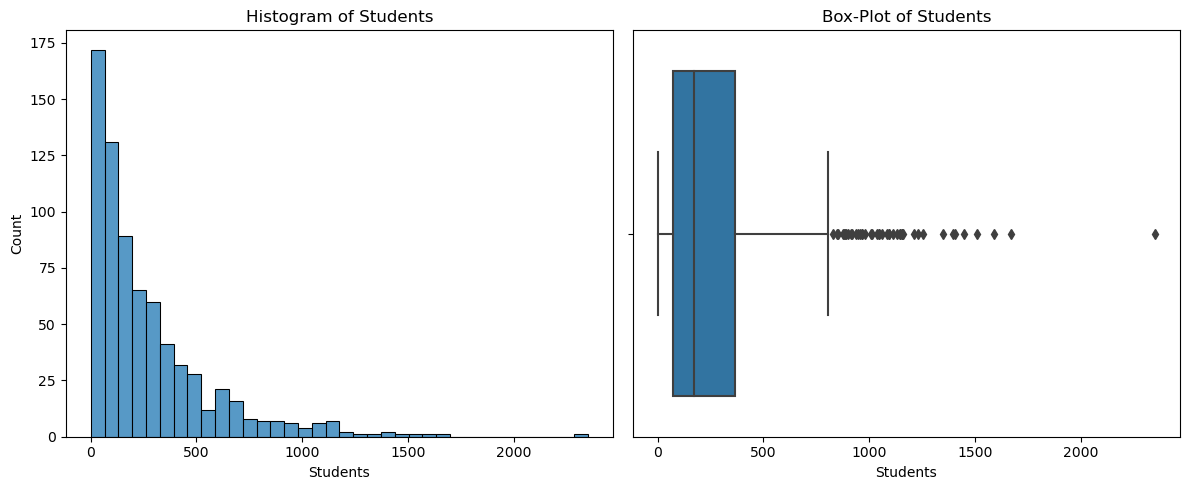

In [244]:
# Students
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(x='Students', data=df, ax=axes[0])
axes[0].set_title("Histogram of Students")
sns.boxplot(x='Students', data=df, ax=axes[1])
axes[1].set_title("Box-Plot of Students")
fig.tight_layout()
plt.show()


In [273]:
print(f"Median: {np.median(df['Students'])}")
print(f"Mean: {np.mean(df['Students'])}")
print(f"Max: {np.max(df['Students'])}")
print(f"Min: {np.min(df['Students'])}")

Median: 170.0
Mean: 270.820193637621
Max: 2349
Min: 1


The distribution is right-skewed, meaning that with an increase in the total number of students that the teacher had, the frequency of such teachers decreases.

Also, from boxplot we can claim that the median of the "Students" is 170, and the middle 50% of all teachers had no more than about 500 students.

Also, there is one isolated outlier with the value of over 2000. Let's deal with this outlier.

In [250]:
df.loc[df['Students'] == 2349]

,Name,Rating,Students,Lessons,Attendance(%),Response(%),Reviews,Price(USD),Link
127,Liezel,4.9,2349,8512,100,100,1,5.0,https://www.italki.com/en/teacher/1421691/english


Since this teacher conducted 8512 lessons, the value of 2349 students is pretty fair, so it's not typing error.

### Lessons

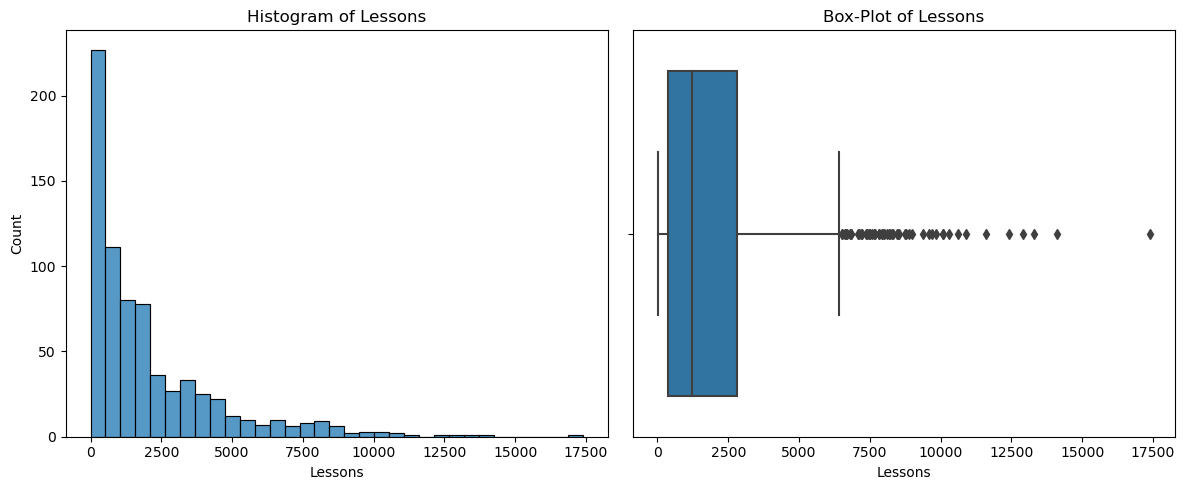

In [211]:
# Lessons
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(x='Lessons', data=df, ax=axes[0])
axes[0].set_title("Histogram of Lessons")
sns.boxplot(x='Lessons', data=df, ax=axes[1])
axes[1].set_title("Box-Plot of Lessons")
fig.tight_layout()
plt.show()

In [272]:
print(f"Median: {np.median(df['Lessons'])}")
print(f"Mean: {np.mean(df['Lessons'])}")
print(f"Max: {np.max(df['Lessons'])}")
print(f"Min: {np.min(df['Lessons'])}")

Median: 1208.0
Mean: 2064.2807745504842
Max: 17400
Min: 1


The distribution is right-skewed, meaning that with an increase in the total number of lessons that the teacher conducted, the frequency of such teachers decreases.

Also, from boxplot we can claim that the median of the "Lessons" is 1208, and the middle 50% of all teachers conducted slightly more than 2500 lessons.

Also, there is one isolated outlier with the value close to 7500. Let's deal with this outlier.

In [252]:
df.loc[df['Lessons'] == 17400]

,Name,Rating,Students,Lessons,Attendance(%),Response(%),Reviews,Price(USD),Link
164,Daniel Borsody,5.0,947,17400,100,100,609,5.0,https://www.italki.com/en/teacher/972313/english


Even though the total number of students the teacher had is not so big, it might mean that most of the students stayed to continue learning English with this teacher after the trial lesson, which is a very good point

### Attendance(%)

In [253]:
# Unique elements of Attendance(%):
print(df['Attendance(%)'].unique())

[ 99 100  98  93  97  95]


Since we have 6 unique values of variable "Attendance(%)", the variable refers to categorical variable, so let's build the count-plot for it.

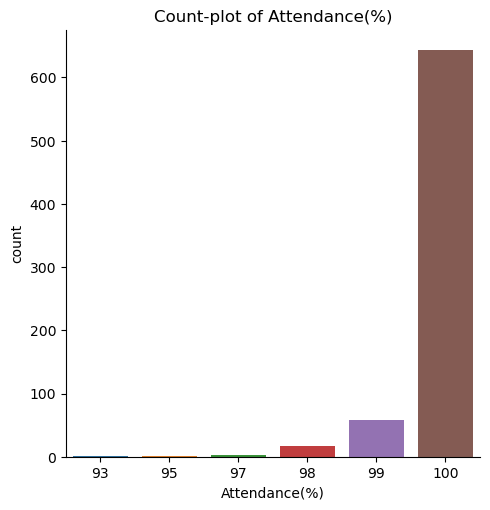

In [254]:
# Attendance(%)

sns.catplot(x='Attendance(%)', data=df, kind='count')
plt.title('Count-plot of Attendance(%)')
plt.show()

The count-plot shows that the more % of attendance the teacher has, the greater the number of such teachers.

In [263]:
Attendance_count = pd.DataFrame(df['Attendance(%)'].value_counts())

list_prop = []
for val in Attendance_count.index:
    count = Attendance_count.loc[val, 'Attendance(%)']
    list_prop.append(count/df.shape[0] * 100)
    
Attendance_count['Proportion(%)'] = list_prop
Attendance_count.columns = ['Attendance_count', 'Proportion(%)']
Attendance_count

,Attendance_count,Proportion(%)
100,643,88.934993
99,58,8.022130
98,17,2.351314
97,3,0.414938
93,1,0.138313
95,1,0.138313


The most frequent percent of attendance is 100 with number of 643, which makes up about 89% of all "Attendance(%)" values.

The least frequent ones are 93 and 95 with just a single occurrences, that make up about 0.14% of all "Attendance(%)" values each.

### Response(%) 

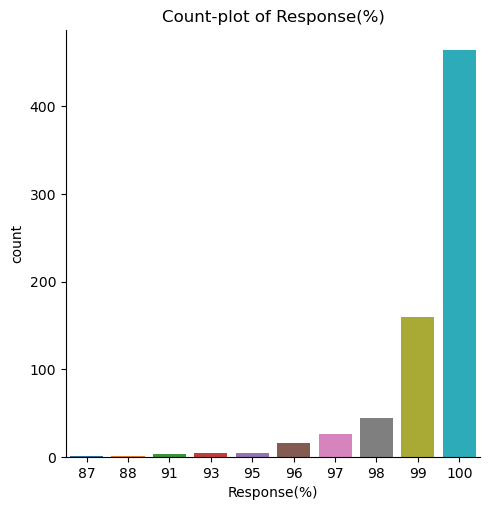

In [257]:
# Response(%)

sns.catplot(x='Response(%)', data=df, kind='count')
plt.title('Count-plot of Response(%)')
plt.show()

The count-plot shows that the more % of response the teacher has, the greater the number of such teachers.

In [265]:
Response_count = pd.DataFrame(df['Response(%)'].value_counts())

list_prop = []
for val in Response_count.index:
    count = Response_count.loc[val, 'Response(%)']
    list_prop.append(count/df.shape[0] * 100)
    
Response_count['Proportion(%)'] = list_prop
Response_count.columns = ['Response_count', 'Proportion(%)']
Response_count

,Response_count,Proportion(%)
100,464,64.177040
99,160,22.130014
98,44,6.085754
97,26,3.596127
96,16,2.213001
93,4,0.553250
95,4,0.553250
91,3,0.414938
88,1,0.138313
87,1,0.138313


The most frequent percent of response is 100 with number of 464, which makes up about 64% of all "Response(%)" values.

The least frequent ones are 88 and 87 with just a single occurrences, that make up about 0.14% of all "Response(%)" values each.

### Reviews 

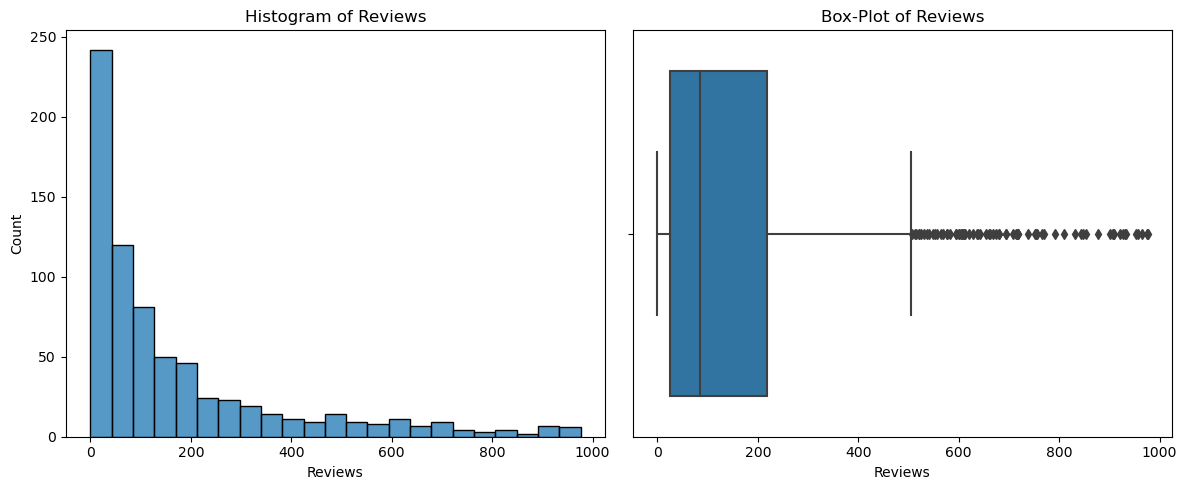

In [266]:
# Reviews

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(x='Reviews', data=df, ax=axes[0])
axes[0].set_title("Histogram of Reviews")
sns.boxplot(x='Reviews', data=df, ax=axes[1])
axes[1].set_title("Box-Plot of Reviews")
fig.tight_layout()
plt.show()

In [271]:
print(f"Median: {np.median(df['Reviews'])}")
print(f"Mean: {np.mean(df['Reviews'])}")
print(f"Max: {np.max(df['Reviews'])}")
print(f"Min: {np.min(df['Reviews'])}")

Median: 84.0
Mean: 171.45781466113417
Max: 976
Min: 0


The distribution is right-skewed, meaning that with an increase in the total number of reviews that the teacher has, the frequency of such teachers decreases.

Also, from boxplot we can claim that the median of the "Reviews" is 84, and the middle 50% of all teachers have slightly more than 200 reviews.


### Price(USD) 

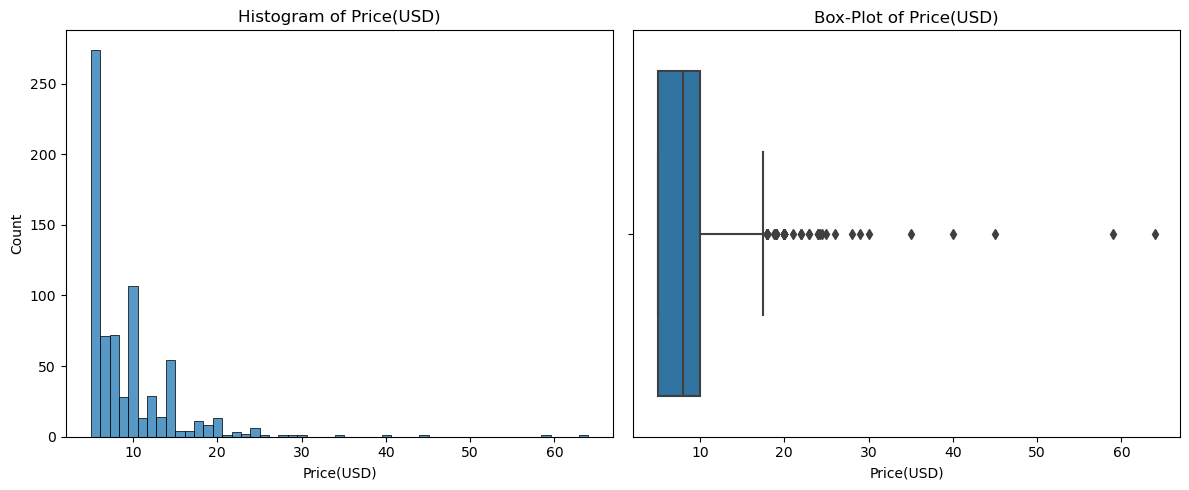

In [216]:
# Price(USD)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(x='Price(USD)', data=df, ax=axes[0])
axes[0].set_title("Histogram of Price(USD)")
sns.boxplot(x='Price(USD)', data=df, ax=axes[1])
axes[1].set_title("Box-Plot of Price(USD)")
fig.tight_layout()
plt.show()

In [270]:
print(f"Median: {np.median(df['Price(USD)'])}")
print(f"Mean: {np.mean(df['Price(USD)'])}")
print(f"Max: {np.max(df['Price(USD)'])}")
print(f"Min: {np.min(df['Price(USD)'])}")

Median: 8.0
Mean: 9.215297372060858
Max: 64.0
Min: 5.0


The distribution is right-skewed, meaning that on average with an increase in the price for 1 trial lesson, the number of teachers teaching for this price decreases.

Also, from boxplot we can claim that the median of the "Price(USD)" is 8, and the middle 50% of all teachers
has the price for 1 trial lesson with value slightly less than 20 USD.

Also, there are two isolated outliers with the values around the 60 USD.

## Bivariate plots

In [274]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           723 non-null    object 
 1   Rating         723 non-null    float64
 2   Students       723 non-null    int64  
 3   Lessons        723 non-null    int64  
 4   Attendance(%)  723 non-null    int64  
 5   Response(%)    723 non-null    int64  
 6   Reviews        723 non-null    int64  
 7   Price(USD)     723 non-null    float64
 8   Link           723 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 51.0+ KB


### Price(USD) - Rating

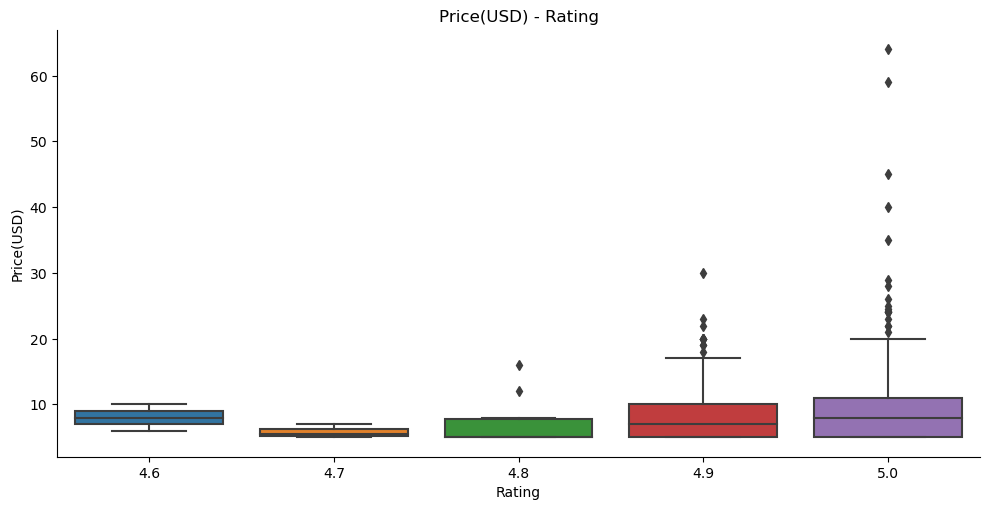

In [283]:
# Price(USD) - Rating

sns.catplot(y='Price(USD)',x='Rating',data=df, kind="box",height=5, aspect=2)
plt.title('Price(USD) - Rating')
plt.show()

The boxplot shows the relationship between Rating (Categorical) and Price(USD) (Continuous Numerical).

- The median price for trial lesson stay relatively stable across ratings 4.6 to 4.9, but increases slightly at rating of 5.0. Which is quite logical, because teachers with an impeccable reputation should receive more.
- The IQR for prices at ratings 4.6 and 4.7 are quite narrow, suggesting less variability in price. The 5.0 rating has the widest IQR, indicating a larger variability in prices.
- The spread of prices seems to increase, with Rating increases, except rating = 4.6, whose range is almost the same as with rating = 4.8. 
- Prices for  trial lesson for ratings of 5.0 also show a higher range of outliers, suggesting that there can be premium-teachers with perfect rating and with a significantly higher, than average price for the trial lesson.


### Price(USD) - Attendance(%)

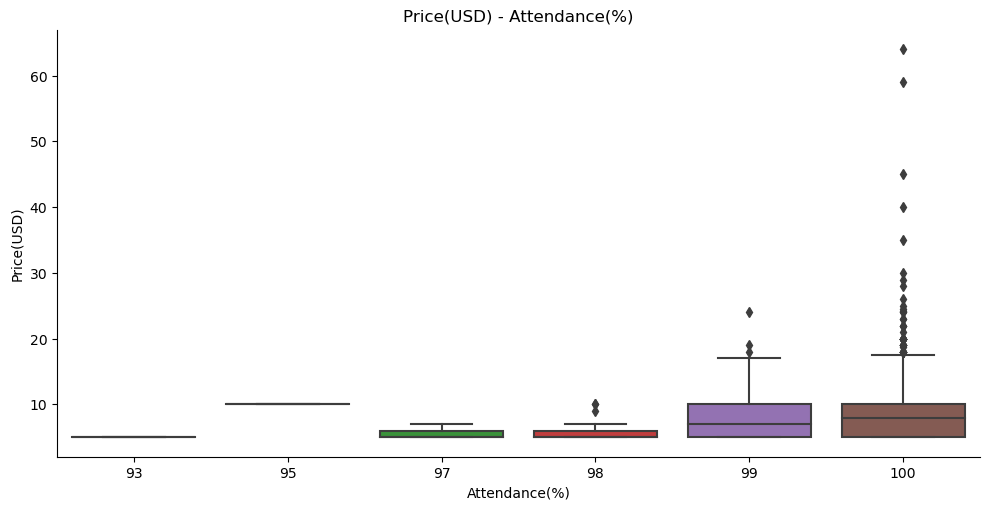

In [284]:
# Price(USD) - Attendance(%)

sns.catplot(y='Price(USD)',x='Attendance(%)',data=df, kind="box",height=5, aspect=2)
plt.title('Price(USD) - Attendance(%)')
plt.show()

The boxplot shows the relationship between Attendance(%) (Discrete) and Price(USD) (Continuous Numerical).

- Not taking into account Attendance values 93 and 95 (due to their single occurance), we can say that the median value of Price is increasing with % of attendance increasing. So, the greates mean price value is at the attendance = 100%
- Also, the range of price is the same for pair of Attendance values 97 and 98, and pair of Attendance values 99 and 100.
- Prices for trial lesson for Attendance of 100% also show a higher range of outliers, suggesting that there can be premium-teachers with perfect Attendance level and with a significantly higher, than average price for the trial lesson. 

### Price(USD) - Response(%)

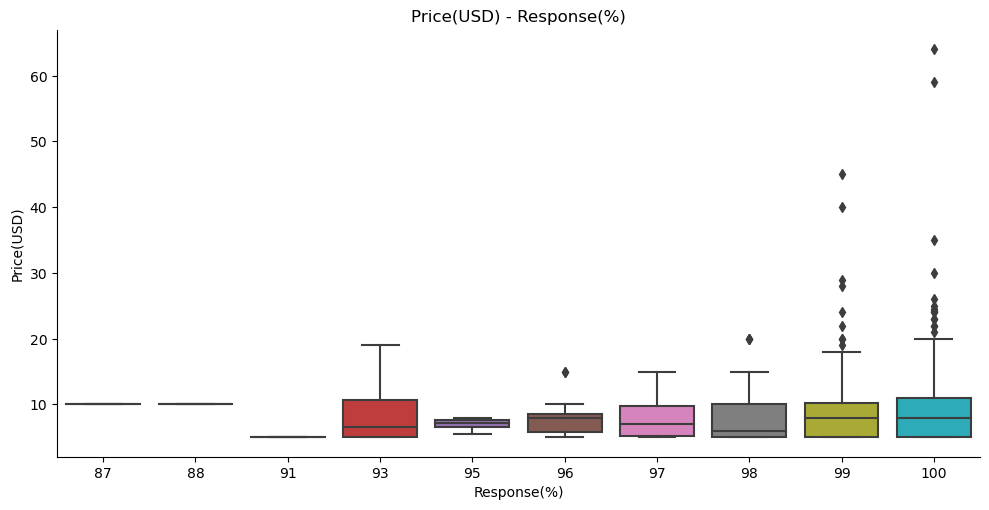

In [285]:
# Price(USD) - Response(%)

sns.catplot(y='Price(USD)',x='Response(%)',data=df, kind="box",height=5, aspect=2)
plt.title('Price(USD) - Response(%)')
plt.show()

The boxplot shows the relationship between Response(%) (Discrete) and Price(USD) (Continuous Numerical).

- Rising in values from 95 to 100, we see the smooth increase in the price range.
- Not taking into account Response values 87 and 88 (due to their single occurance), we can say that the greatest mean price value is at the response = 100%
- Prices for trial lesson for Response of 100% also show a higher range of outliers, suggesting that there can be premium-teachers with perfect Response level and with a significantly higher, than average price for the trial lesson.

### Price(USD) - Students

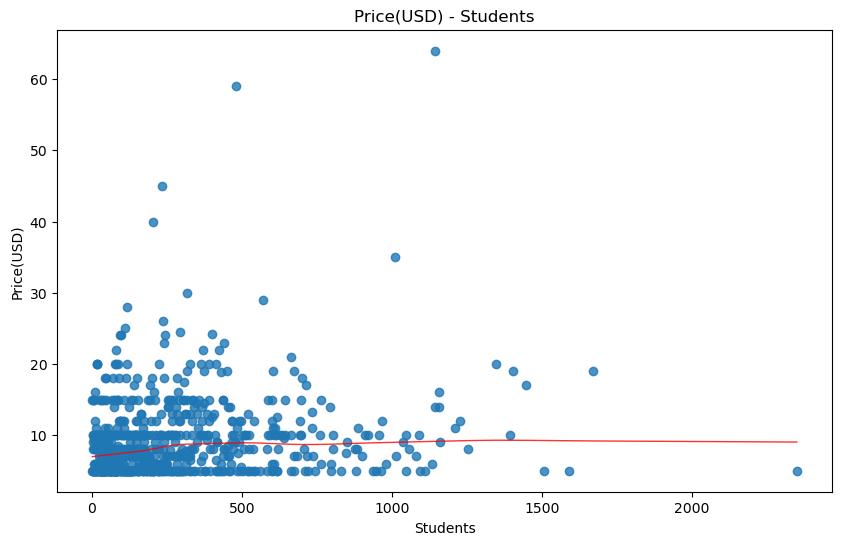

In [295]:
# Price(USD) - Students

fig, ax = plt.subplots(figsize=(10, 6))
reg = sns.regplot(x='Students', y='Price(USD)', data=df, ci=False, lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.title('Price(USD) - Students')
plt.show()

No relationship between total number of students the teacher taught and teacher's price for the trial lesson.

### Price(USD) - Lessons

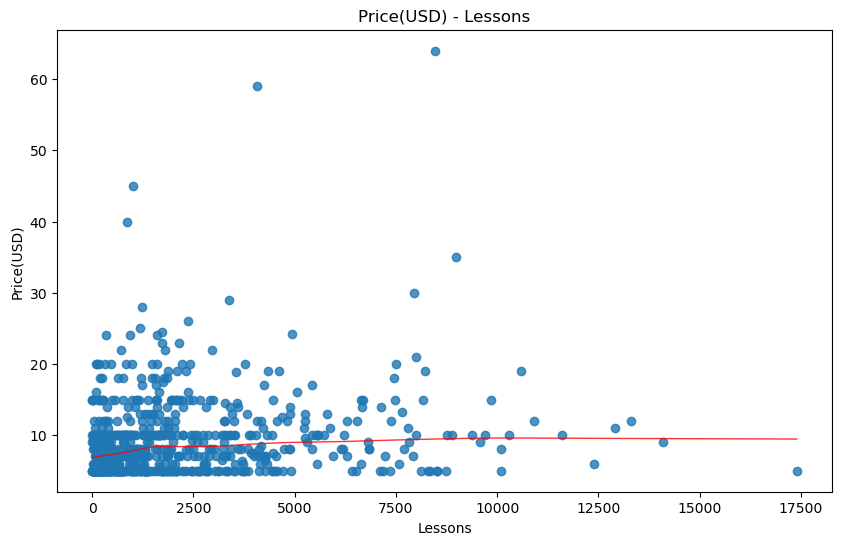

In [304]:
# Price(USD) - Lessons

fig, ax = plt.subplots(figsize=(10, 6))
reg = sns.regplot(x='Lessons', y='Price(USD)', data=df, ci=False, lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.title('Price(USD) - Lessons')
plt.show()

No relationship between total number of lessons the teacher conducted and teacher's price for the trial lesson.

### Price(USD) - Reviews

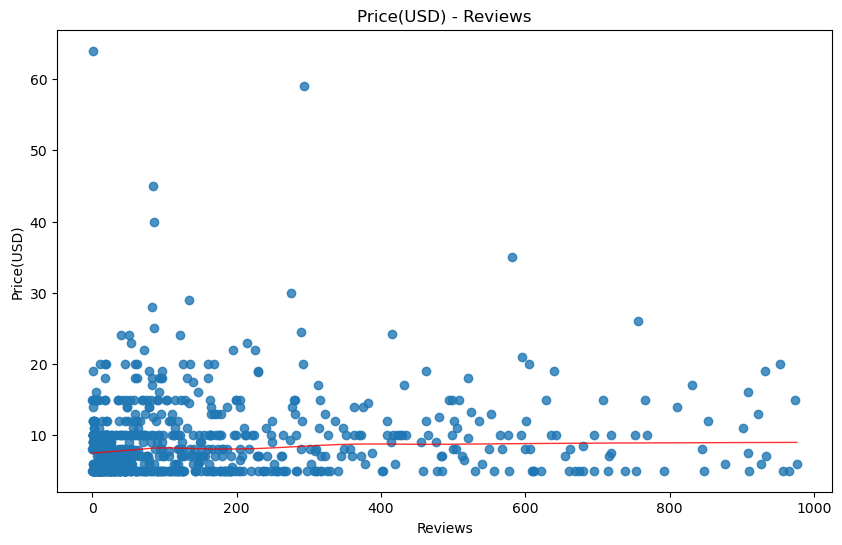

In [305]:
# Price(USD) - Reviews

fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x='Reviews', y='Price(USD)', data=df, ci=False, lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.title('Price(USD) - Reviews')
plt.show()

No relationship between total number of reviews the teacher has and teacher's price for the trial lesson.

### Reviews - Students

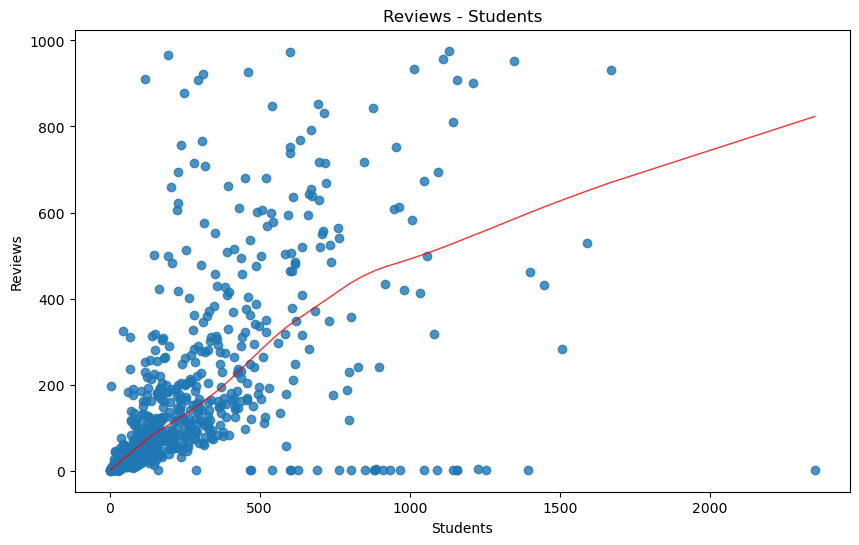

In [306]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x='Students', y='Reviews', data=df, ci=False, lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.title('Reviews - Students')
plt.show()

Positive monotonic non-linear relationship: The more students the teacher had, the more reviews the teacher has.

### Reviews - Lessons

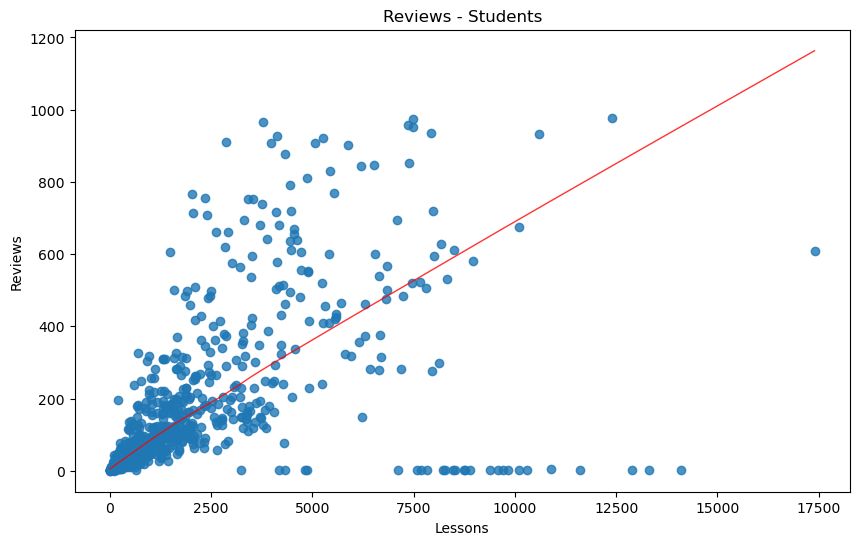

In [307]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x='Lessons', y='Reviews', data=df, ci=False, lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.title('Reviews - Students')
plt.show()

Positive linear relationship: the more lessons the teacher conducted, the more reviews the teacher has.